In [1]:
#PATRICK MAZZA - ASSIGNMENT_ONE 
#Import all the libraires
import numpy as np
import logging
import sys
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.stats import multivariate_normal as mvn
from skimage.segmentation import flood, flood_fill
import importlib
from roipoly import RoiPoly
import numpy as np 
import skimage
from skimage import data, util
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import nums_from_string
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import skimage.measure as measure



In [2]:
#Load the saved numpy txt files
lut = np.loadtxt('model.txt')
model = pickle.load(open("model.pickle", 'rb'))


In [3]:
#With test Set
data_directory_test = '/Users/patrickmazza/Hmework1Lee/ECE5242Proj1-test 2'
all_files = os.listdir(data_directory_test)
test_data = np.zeros((len(all_files), 800, 600, 3))
for index, file in enumerate(all_files):
    if file[-4:] == '.png':
        img = cv2.imread(os.path.join(data_directory_test, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_data[index, :, :, :] = img



In [4]:
#Run this for the test images that you load

test_images_corrected = test_data.reshape(-1,3)//4
prediction_for_mask_test = lut[(test_images_corrected[:,0]*(64)+test_images_corrected[:,1]*64*64+test_images_corrected[:,2]).astype(int)]
prediction_for_mask_test = prediction_for_mask_test.reshape(test_data.shape[:-1])




In [5]:
#Spoken about in class that we can use the img errosion process
#https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/

kernel = np.ones((5, 5), np.uint8)
img_erosion = prediction_for_mask_test
for i in range(prediction_for_mask_test.shape[0]):
    for _ in range(3):
        img_erosion[i,:,:]= cv2.erode(img_erosion[i,:,:].astype(np.uint8), kernel, iterations=1)
        img_erosion[i,:,:]= cv2.dilate(img_erosion[i,:,:].astype(np.uint8), kernel, iterations=1)

In [6]:
#Skimage package to segment area in the effort of returning centroids in a structured array
regionality = []
for i in range(prediction_for_mask_test.shape[0]):
        label_img = skimage.measure.label((img_erosion[i,:,:]), connectivity=img_erosion.ndim-1)
        regionality.append(skimage.measure.regionprops(label_img))
        

In [7]:
#Aquiring the area for each instance
areas = []
for i in regionality:
    tempar = [x.area for x in i]
    areas.append(np.max(tempar))
areas = np.array(areas)
print(areas)

[ 3670 31106  2804 22981  1087]


In [8]:
#This is the module you load above 
distances = model.predict(np.log(areas.reshape(-1,1)))


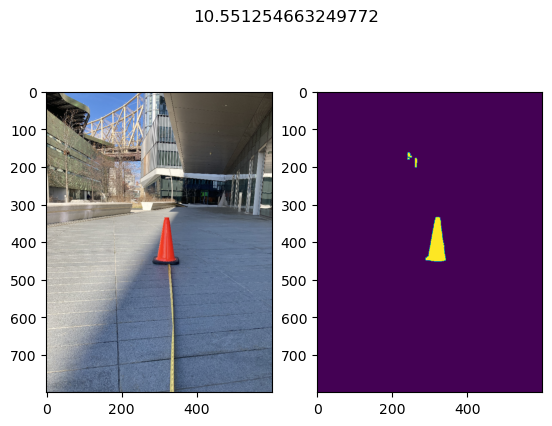

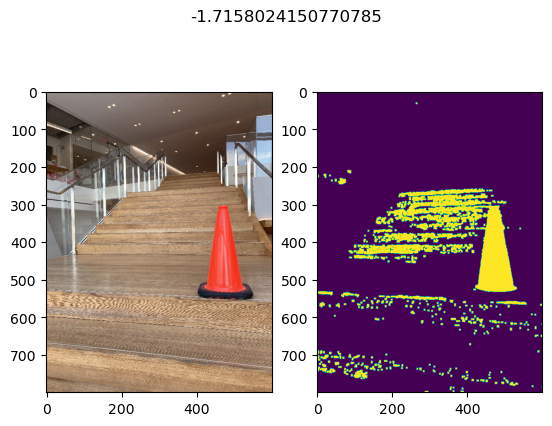

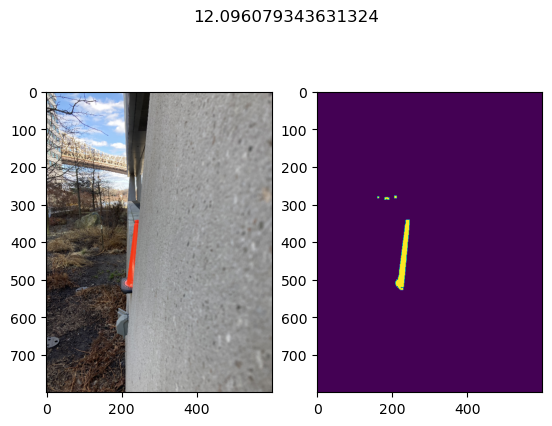

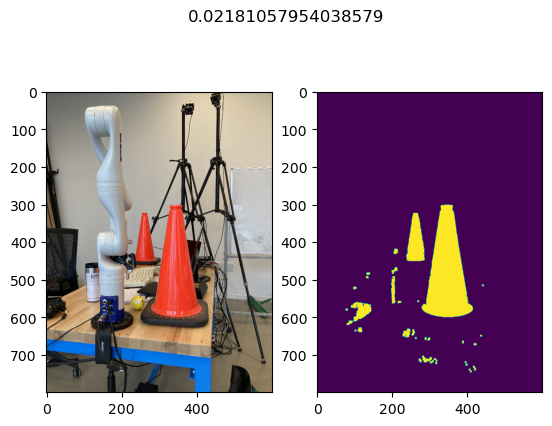

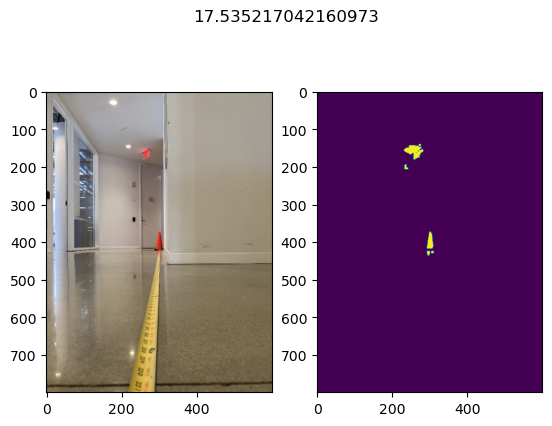

In [9]:
#Distance to the cones is above their respected pictures
for i in range(len(test_data)):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(test_data[i,:,:,:]/255)
    ax[1].imshow(img_erosion [i,:,:]/255)
  
    fig.suptitle(distances[i])


In [10]:
   #New cell
def calculate_distance(height):
    focal_length = 2.186 #mm, from calculation 
    return np.round(432*focal_length/height,2)

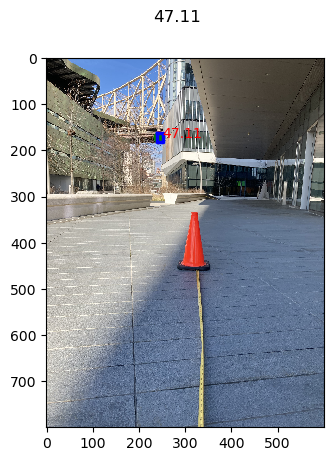

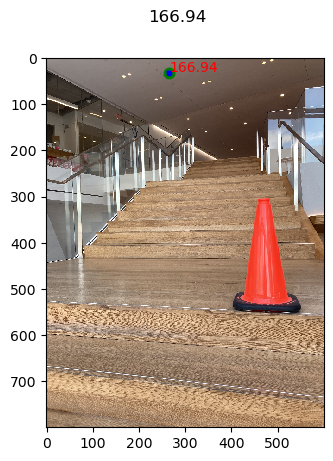

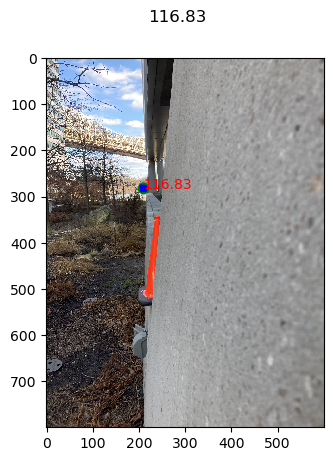

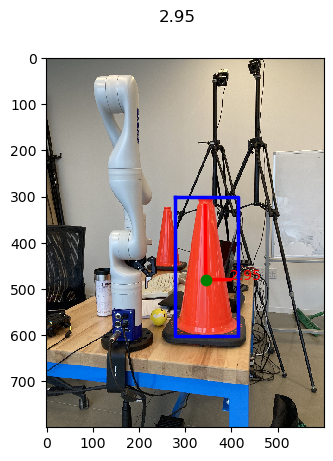

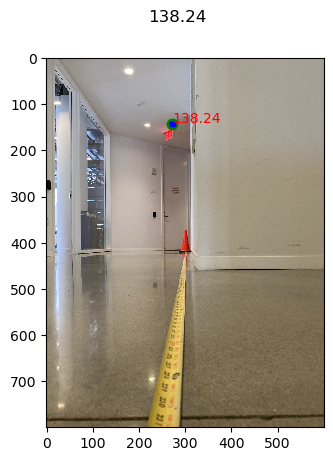

In [11]:
for i in range(prediction_for_mask_test.shape[0]):
    label_img = skimage.measure.label((img_erosion[i,:,:]), connectivity=img_erosion.ndim-1)
    regions = skimage.measure.regionprops(label_img)
    
    fig, ax = plt.subplots()
    ax.imshow(test_data[i,:,:,:]/255, interpolation='nearest')
    
    for props in regions:    
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=2.5)
        
        
        dist_to_cone = 0 #New
        if len(regions) > 0: #New
            dist_to_cone = calculate_distance(props.axis_major_length)  #New
        
        ax.text(x1,y1,str(dist_to_cone), color = 'r') #New

        fig.suptitle(dist_to_cone) #distances[i])
        plt.show()